Use of StatReg.

Simple RC - chain.

$U_{in} - input, U_{out} - output$

$RC\dot{U}_{out} = -U_{out}+U_{in}$

$RC = \tau$, $$U_{out}(t) = e^{-\frac{t}{\tau}}U_{out}(t=0)+e^{-\frac{t}{\tau}}\int_0^t{e^{\frac{x}{\tau}}U_{in}(x)dx}$$

When $U_{out}(t=0) = 0$ then 
$$U_{out}(t) = \int_0^T{K(x,t)U_{in}(x)dx}$$

$K(x,t) = \begin{cases} e^{\frac{x-t}{\tau}},& x-t<=0\\ 0,& x-t>0 \end{cases}$

Define the kernel

In [1]:
using PyCall
# import Pkg; Pkg.add("StatReg") without crutchs
include("../src/gauss_error.jl")
include("../src/kernels.jl")
include("../src/basis.jl")
#This includes must be changed into "using StatReg"

tau = 1.
function kernel(x::Float64, y::Float64)
    if x <= y
        return exp( (x-y)/tau)
    end
    return 0.
end

kernel (generic function with 1 method)

Define $T=2\pi, tau = 1,\phi(t)=sin(t)+\cfrac{1}{2} .$ out will be $f(t) = \cfrac{1}{2}(\sin{t}-\cos{t}+1)$

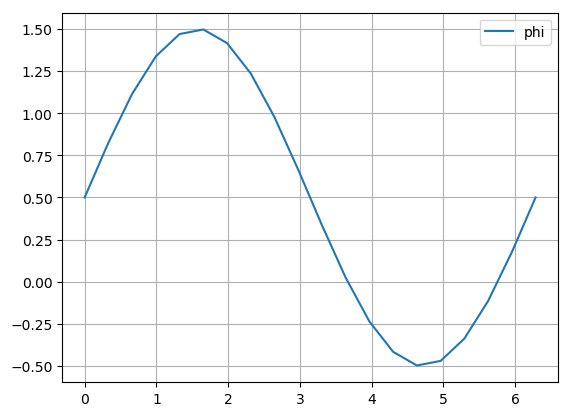

In [2]:
T = 2*pi
a = 0.
b = T

function phi(x::Float64)
    return sin(x)+1/2
end
function f_expected(y::Float64)
    return (sin(y)-cos(y)+1)/2
end

#creating x array
x = collect(range(a, stop=b, length=20))

using PyPlot
phi_plot = plot(x, phi.(x))
gca().legend(("phi",))
gca().grid()

Then, define $f(y)$, which is affected $\phi(x)$ by $K(x,y)$ but without noise

In [3]:
f_clear = y -> quadgk(x -> kernel(x,y) * phi(x), a, b, rtol=10^-5, maxevals=10^7)[1]

#146 (generic function with 1 method)

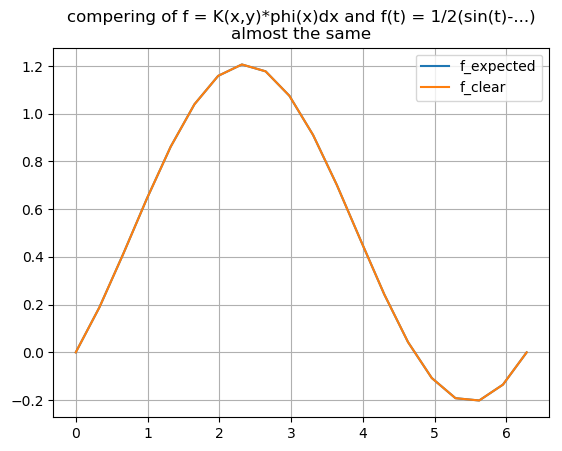

PyObject Text(0.5, 1.0, 'compering of f = K(x,y)*phi(x)dx and f(t) = 1/2(sin(t)-...)\nalmost the same')

In [4]:
plot_expected_f = plot(x, f_expected.(x))
plot_clear_f = plot(x, f_clear.(x))
gca().legend(("f_expected","f_clear"))
gca().grid()
title("compering of f = K(x,y)*phi(x)dx and f(t) = 1/2(sin(t)-...)\nalmost the same")

Than we add a noise   

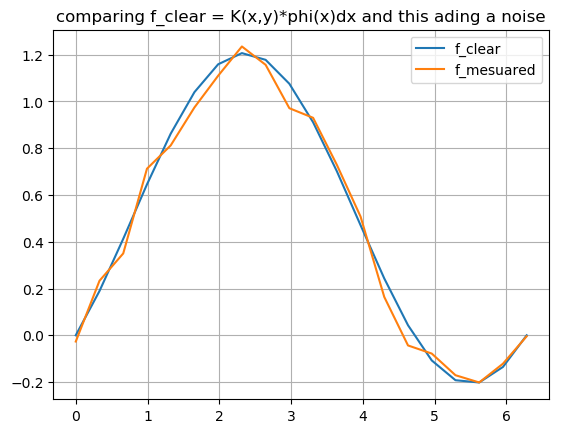

PyObject Text(0.5, 1.0, 'comparing f_clear = K(x,y)*phi(x)dx and this ading a noise')

In [5]:
f_clear_array = f_clear.(x)
eps = 0.05
#change eps and observe difference
max_eps_array = [eps for i = 1:Base.length(f_clear_array)]

using Compat, Random, Distributions

noise_array = []
for sigma in max_eps_array
    n = rand(Normal(0., sigma), 1)[1]
    push!(noise_array, n)
end

f_mesuared_array = f_clear_array + noise_array
plot(x,f_clear_array)
plot(x,f_mesuared_array)
gca().legend(("f_clear","f_mesuared"))
gca().grid()
title("comparing f_clear = K(x,y)*phi(x)dx and this ading a noise")

Now, we choose a basis. FourierBasis is suitable, but we can view another.

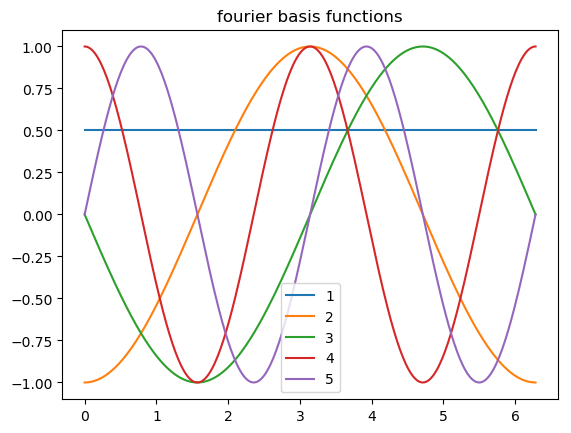

PyObject Text(0.5, 1.0, 'fourier basis functions')

In [6]:
num_of_basis_functions = Int64(10)

work_basis_fourier  = FourierBasis(a,b,num_of_basis_functions)
#10 harmonics => 21 functions including harmony of Freq = 0, f = 0.5
work_basis_legendre = LegendreBasis(a,b,num_of_basis_functions)

x_high_prec_array = collect(range(a, stop=b, length=300))

for index =1:5
    plot(x_high_prec_array, work_basis_fourier.basis_functions[index].f.(x_high_prec_array))
end
gca().legend("12345")
title("fourier basis functions")



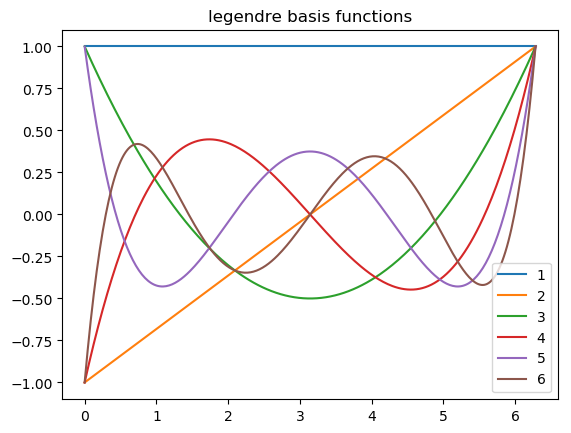

PyObject Text(0.5, 1.0, 'legendre basis functions')

In [7]:
for index =1:6
    plot(x_high_prec_array, work_basis_legendre.basis_functions[index].f.(x_high_prec_array))
end
gca().legend("123456")
title("legendre basis functions")

Now, we define a quadratic form of smoothing operator $\Omega$

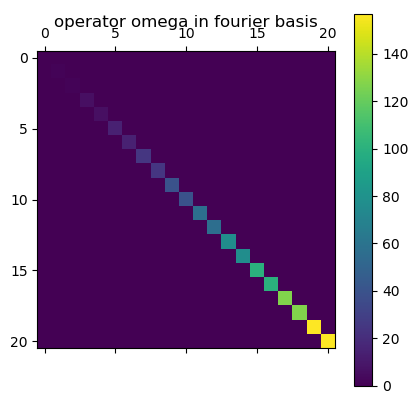

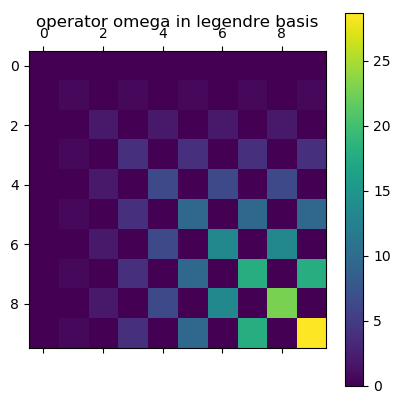

PyObject Text(0.5, 1.05, 'operator omega in legendre basis')

In [8]:
order_of_diff = Int64(1) # = 1,the problem is that only 1 is Int32(1)
operator_omega_fourier = omega(work_basis_fourier,order_of_diff)
operator_omega_legendre = omega(work_basis_legendre,order_of_diff)
matshow(operator_omega_fourier[1])
colorbar()
title("operator omega in fourier basis")
matshow(operator_omega_legendre[1])
colorbar()
title("operator omega in legendre basis")

Next step is define a model

In [9]:
model_geu_fourier = GaussErrorUnfolder(work_basis_fourier, operator_omega_fourier)
model_geu_legendre = GaussErrorUnfolder(work_basis_legendre, operator_omega_legendre)
println()

Then we can get reconstruction of function $\phi(x)$ by method "solve"

We will get phi_reconst_fourier and phi_reconst_legendre

Also, we can easily get reconstrution of $\phi(x)$ by substitution $f(x)$ in equatation 

$\tau\dot{U}_{out} = -U_{out}+U_{in}$

So, as $U_{in} = \phi, U_{out} = f(x), \tau = 1$

then $\phi(x) = f(x)+\dot{f(}x)$

The only problem, is that noise after differentiation can turn to a very hopping function (see in graph "reconstructions")

So, let's reconstruct by StatReg

starting solve
ending solve
starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -1.603817e+02     4.602361e+00
     1    -1.628665e+02     1.776593e+00
     2    -1.632054e+02     5.777041e-02
     3    -1.632057e+02     1.739278e-05
     4    -1.632057e+02     1.244115e-08
     5    -1.632057e+02     0.000000e+00
ending solve_correct
starting solve
ending solve
starting solve
ending solve
starting solve_correct
starting optimal_alpha
starting optimize
Iter     Function value   Gradient norm 
     0    -1.607093e+02     2.680229e+00
     1    -1.618613e+02     8.102484e-01
     2    -1.619599e+02     5.180074e-03
     3    -1.619599e+02     3.754857e-08
     4    -1.619599e+02     4.693572e-09


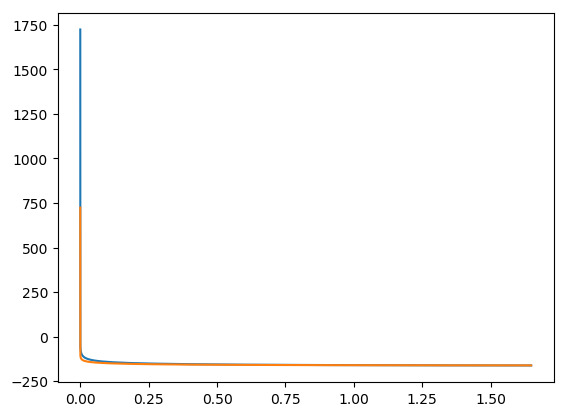

ending solve_correct


Dict{String,Array{Float64,N} where N} with 3 entries:
  "alphas" => [2.42686]
  "coeff"  => [0.480248, -0.988941, -0.00900612, 0.816601, 0.00333151, -0.34568…
  "sig"    => [0.00376355 0.00128212 … -0.000297483 -2.08606e-5; 0.00128212 0.0…

In [10]:
phi_reconst_fourier = solve(model_geu_fourier, kernel, f_mesuared_array, max_eps_array, x)
phi_reconst_legendre = solve(model_geu_legendre, kernel, f_mesuared_array, max_eps_array, x)

In [11]:
phi_reconst_from_fourier = PhiVec(phi_reconst_fourier["coeff"], work_basis_fourier, phi_reconst_fourier["sig"])
phi_reconst_from_legendre = PhiVec(phi_reconst_legendre["coeff"], work_basis_legendre, phi_reconst_legendre["sig"])
println()

Reconstructing by the straight method $\phi(x) = f(x)+\dot{f(}x)$

In [12]:
dfdx = []
for i=1:(length(f_mesuared_array)-1)
    push!(dfdx, (f_mesuared_array[i+1]-f_mesuared_array[i])/(x[i+1]-x[i]) )
end
push!(dfdx,dfdx[length(f_mesuared_array)-1])
phi_straight = dfdx + f_mesuared_array
println()

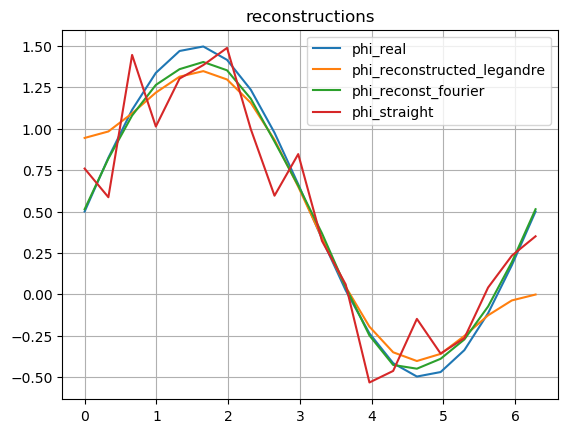

In [13]:
phi_reconst_legendre_values = call(phi_reconst_from_legendre,x)
phi_reconst_legendre_errors = errors(phi_reconst_from_legendre,x)

phi_reconst_fourier_values = call(phi_reconst_from_fourier,x)
phi_reconst_fourier_errors = errors(phi_reconst_from_fourier,x)

plot(x,phi.(x))
plot(x,phi_reconst_legendre_values)
plot(x,phi_reconst_fourier_values)
plot(x,phi_straight)
gca().legend(("phi_real","phi_reconstructed_legandre","phi_reconst_fourier","phi_straight"))
gca().grid()
title("reconstructions")
println()